# Yearly Maxima Return Level Estimation: Example 4

This notebook provides a practical implementation using the `R` language of the guidelines for statistical analysis of yearly maxima edicted by the FOEN. In particular, we aim to estimate the return level function, and in particular the 10-year return level, of groundwater level that can be used as reference for civil engineering infrastructure design. 

Example 4 that is treated in this notebook is the most complex of the four datasets that acompanies the guidelines. This example requires multiple advanced tools, such as trend estimation and increased block sizes, to obtain a sample of observations satifiying the necessary assumptions for statistical analysis and accurate uncertainty estimation.

The analysis is performed thanks the the `R` language and requires mulitples `R` packages that needs to be installed before starting the analysis. The latter can be done with commands such as `install.packages("lubridate")` exemplifying intallationg of the lubridate package.

On the Renku platform where the guildelines' notebooks are strored and share, the project has been prepared with all packages installed for easiest reproduction.

In [1]:
# Load necessary libraries

# Library for easy date manipulation
library(lubridate) 

#Library for estimation of parametric models using l-moment matching
library(lmom)

#Library for estimation of parametric EVT models using maximum likelihood
library(evd)

# Library for automatic trend estimation
library(mgcv)

# Library for data manipulation
library(dplyr)

# Libraries for data plotting
library(ggplot2)
library(repr)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: nlme

This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.


Attaching package: ‘dplyr’


The following object is masked from ‘package:nlme’:

    collapse


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




With all necessary libraries now loaded, we import the data into the R environment. In our case, the data is stored as a `.csv` file with four columns and corresponding titles. Thanks to the `read.csv` function in `R`, we convert the csv into a data.frame object, the `R` representation of datasets, that has the following columns:
* Zeitstempel (date object): date (and time if available) of the measurement,
* Wert (numeric): measured groundwater level,
* Jahre (numeric): Year of the measurement used to compute yearly maxima,
* Zeitstempel_seit_ersten_wert (numeric): numerical time since the beginning of the measures.

File format other than `.csv` are possible, but the `R` code must be adapted accordingly. Extensive documentation on data importation in `R` is widely available on the web.

In [2]:
# Read and import data from csv file
data <- read.csv("../data/data_groundwater_level_4.csv", header = TRUE, sep = ",")

# Converte date as string into date object
data$Zeitstempel <- ymd(data$Zeitstempel)

# Create column with year for block computation
data$Jahre <- (year(data$Zeitstempel))

#Create column with numerical time for trend estimation
data$Zeitstempel_seit_ersten_wert <- as.numeric(data$Zeitstempel) - as.numeric(data$Zeitstempel[1]) 

# Display first 6 rows of the data 
head(data)

,Zeitstempel,Wert,Jahre,Zeitstempel_seit_ersten_wert
,<date>,<dbl>,<dbl>,<dbl>
1,1977-01-01,426.78,1977,0
2,1977-01-02,426.78,1977,1
3,1977-01-03,426.78,1977,2
4,1977-01-04,426.78,1977,3
5,1977-01-05,426.78,1977,4
6,1977-01-06,426.78,1977,5


Thanks the the created dataframe named `data`, we can now start the analysis. Before having a first look at the data, we compute the yearly maxima that we store into another dataframe.

In [3]:
#Compute dataframe of yearly maxima
data_yearly_maxima <- data %>%
                        group_by(Jahre) %>% # Groupe lines by year
                        summarize(Max = max(Wert, na.rm = TRUE),
                                  Date_maxima = Zeitstempel[which.max(Wert)]) # Compute yearly maxima and date of occurence

#Display first 6 rows of the dataframe
head(data_yearly_maxima) 

Jahre,Max,Date_maxima
<dbl>,<dbl>,<date>
1977,429.98,1977-06-20
1978,431.43,1978-05-02
1979,430.64,1979-05-02
1980,431.56,1980-03-15
1981,431.99,1981-12-31
1982,432.97,1982-02-16


We now have all the relevant data to have a first look at the time series of measurement along with the corresponding yearly maxima.

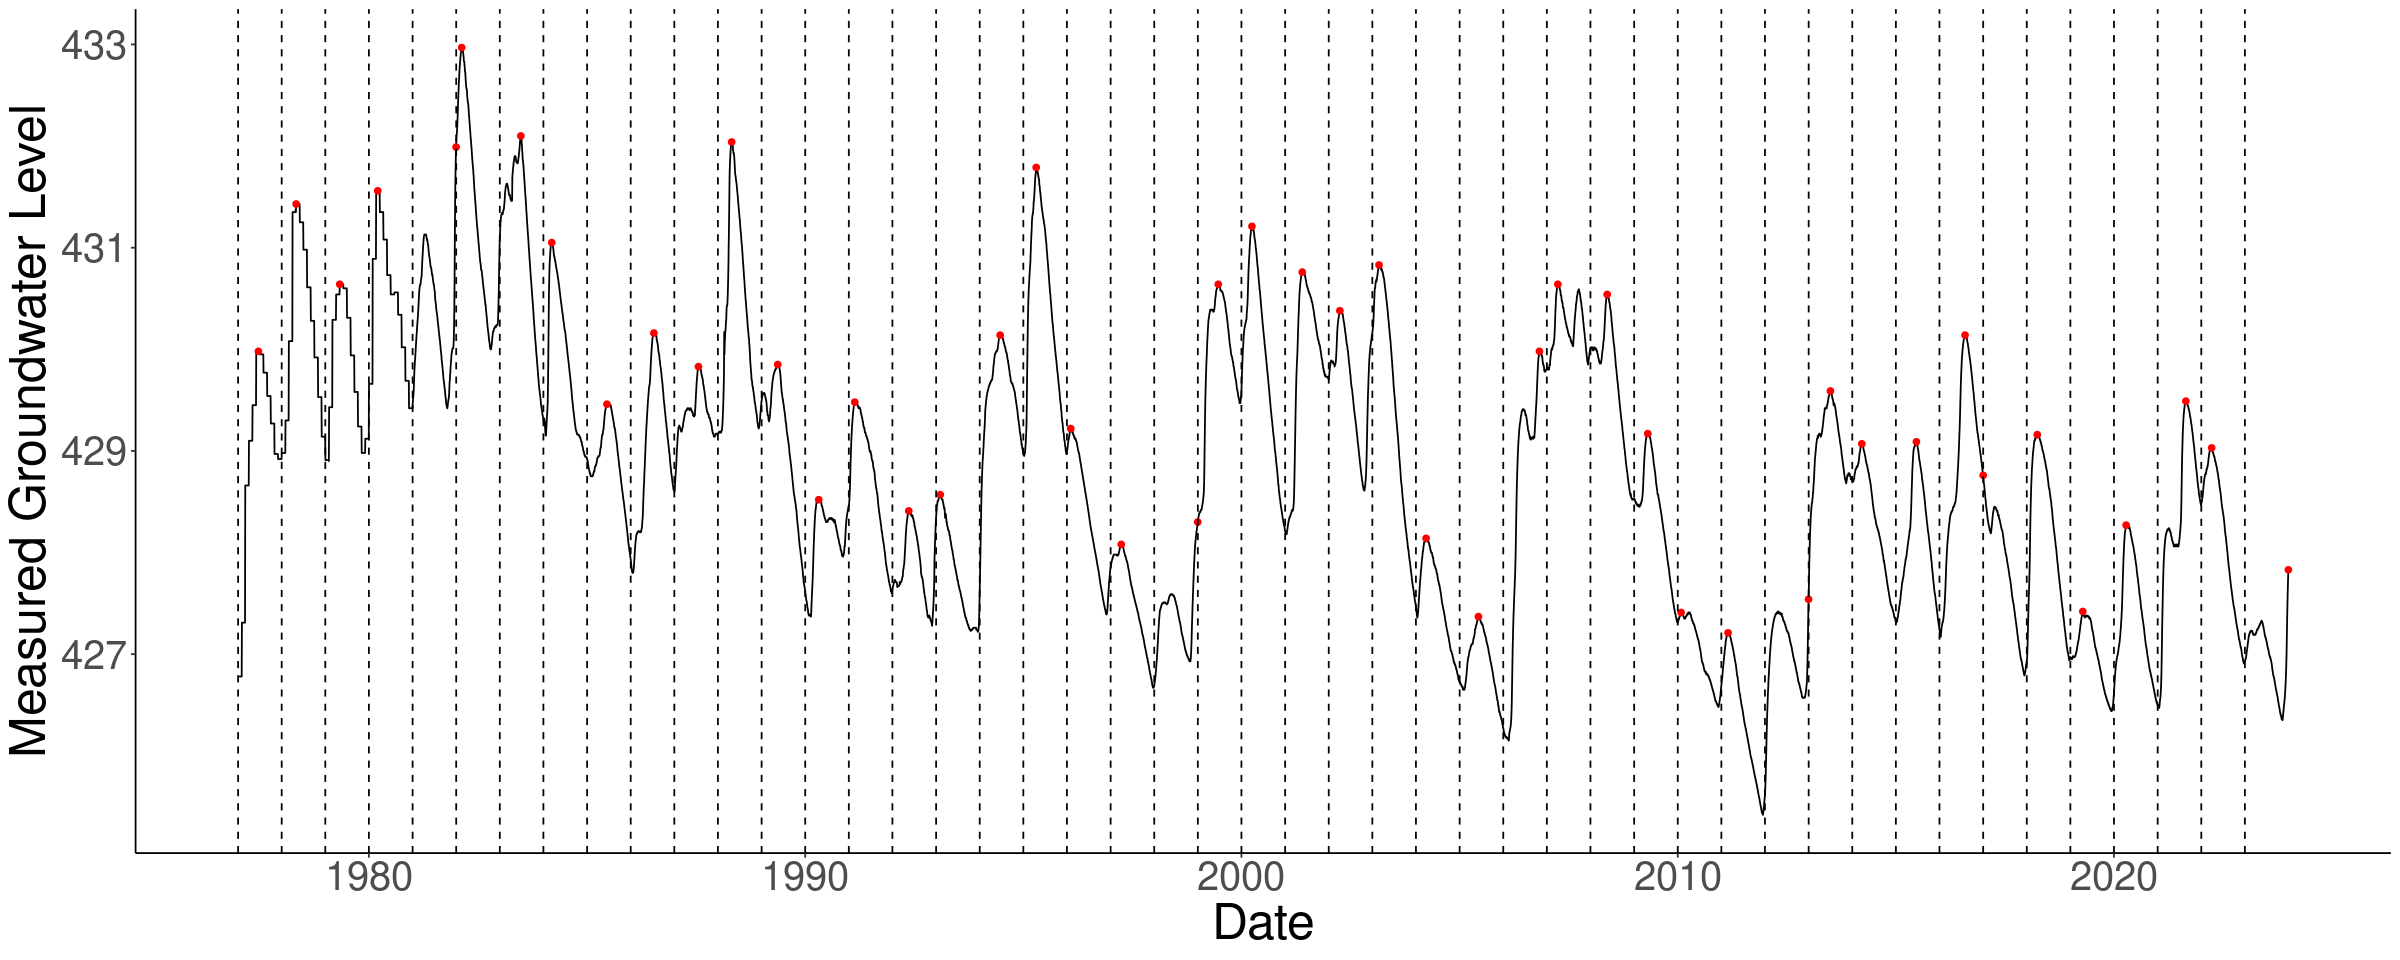

In [4]:
# Increase the plot size
options(repr.plot.width=20, repr.plot.height=8)

# Use the ggplot2 package to display the time series
ggplot(data) + #create plot object
    geom_line(data = data, aes(x = Zeitstempel, y = Wert)) + # add time series of measurements
    geom_point(data = data_yearly_maxima, aes(x = Date_maxima, y = Max), color = "red") + #add maxima as red points
    geom_vline(xintercept = dmy(paste0("01-01-",seq(min(data$Jahre), max(data$Jahre), by = 1))), linetype = "dashed") + #add vertical line for each year
    theme_classic() + #Change template
    theme(text = element_text(size = 30))+ #Increase police size
    xlab("Date") + # X axis name
    ylab("Measured Groundwater Level") #Y axis name

The above plots is extremely informative: we first observe that the time series is not stationatry and that there is a decreasing trend over the years. The distribution of the maxima is thus not "identically distributed"  as the mean over the year cannot be considered constant over time.

Statistical analysis requires "identically distributed" observations, so we will first estimate a trend to standarize the data and make such assumption more realistic.

## Trend estimation and data standardization

The existing trend could be estimated either from the original measurements or directly on the yearly maxima. The  original data contains a much greater quantity information than the yearly maxima alone, as there is many more observations, so the estimation of the trend is much more accurate and efficient with the original data.

In practice, we rely for trend estimation on the `R` package `mgcv` which provides many advanced algorithms to estimate  Generalized Additive Models (GAM). We will make a basic use of the package as a "black-box" that allows fully automaticall to estimate a trend.

*<ins>Technical note</ins>*: the default mode of the `mgcv` package assumes that the data is normally distributed around the estimated trend. This assumption might not hold. However the implementation is robust enough if the data is sufficiently "well behaved", i.e., in our case; if moments of sufficient high order are finite. For groundwater level, we oberve that the tail of the data is in general bounded (see below and examples 1-3) which ensures appropriate behaviour of the `mgcv` package. Would that not be the case, more advanced functionalities would be required. In this case, the full documentation for `mgcv` can be found [here](https://cran.r-project.org/web/packages/mgcv/mgcv.pdf). 

In [5]:
# Estimate the GAM model using mgcv
gam_trend_estimation <- gam(Wert~s(Zeitstempel_seit_ersten_wert), data = data)

# Compute the trend for existing dates using the estimated model
data$trend <- predict(gam_trend_estimation, data, type = 'response', se.fit = FALSE)

#Compute the standardized data by removing trend from original data
data$Wert_standardized <- data$Wert - data$trend

A GAM model has been estimated automatically and the associated trend computed. We now plot the original data with the estimated trend to assess if the package did a reasonable job:

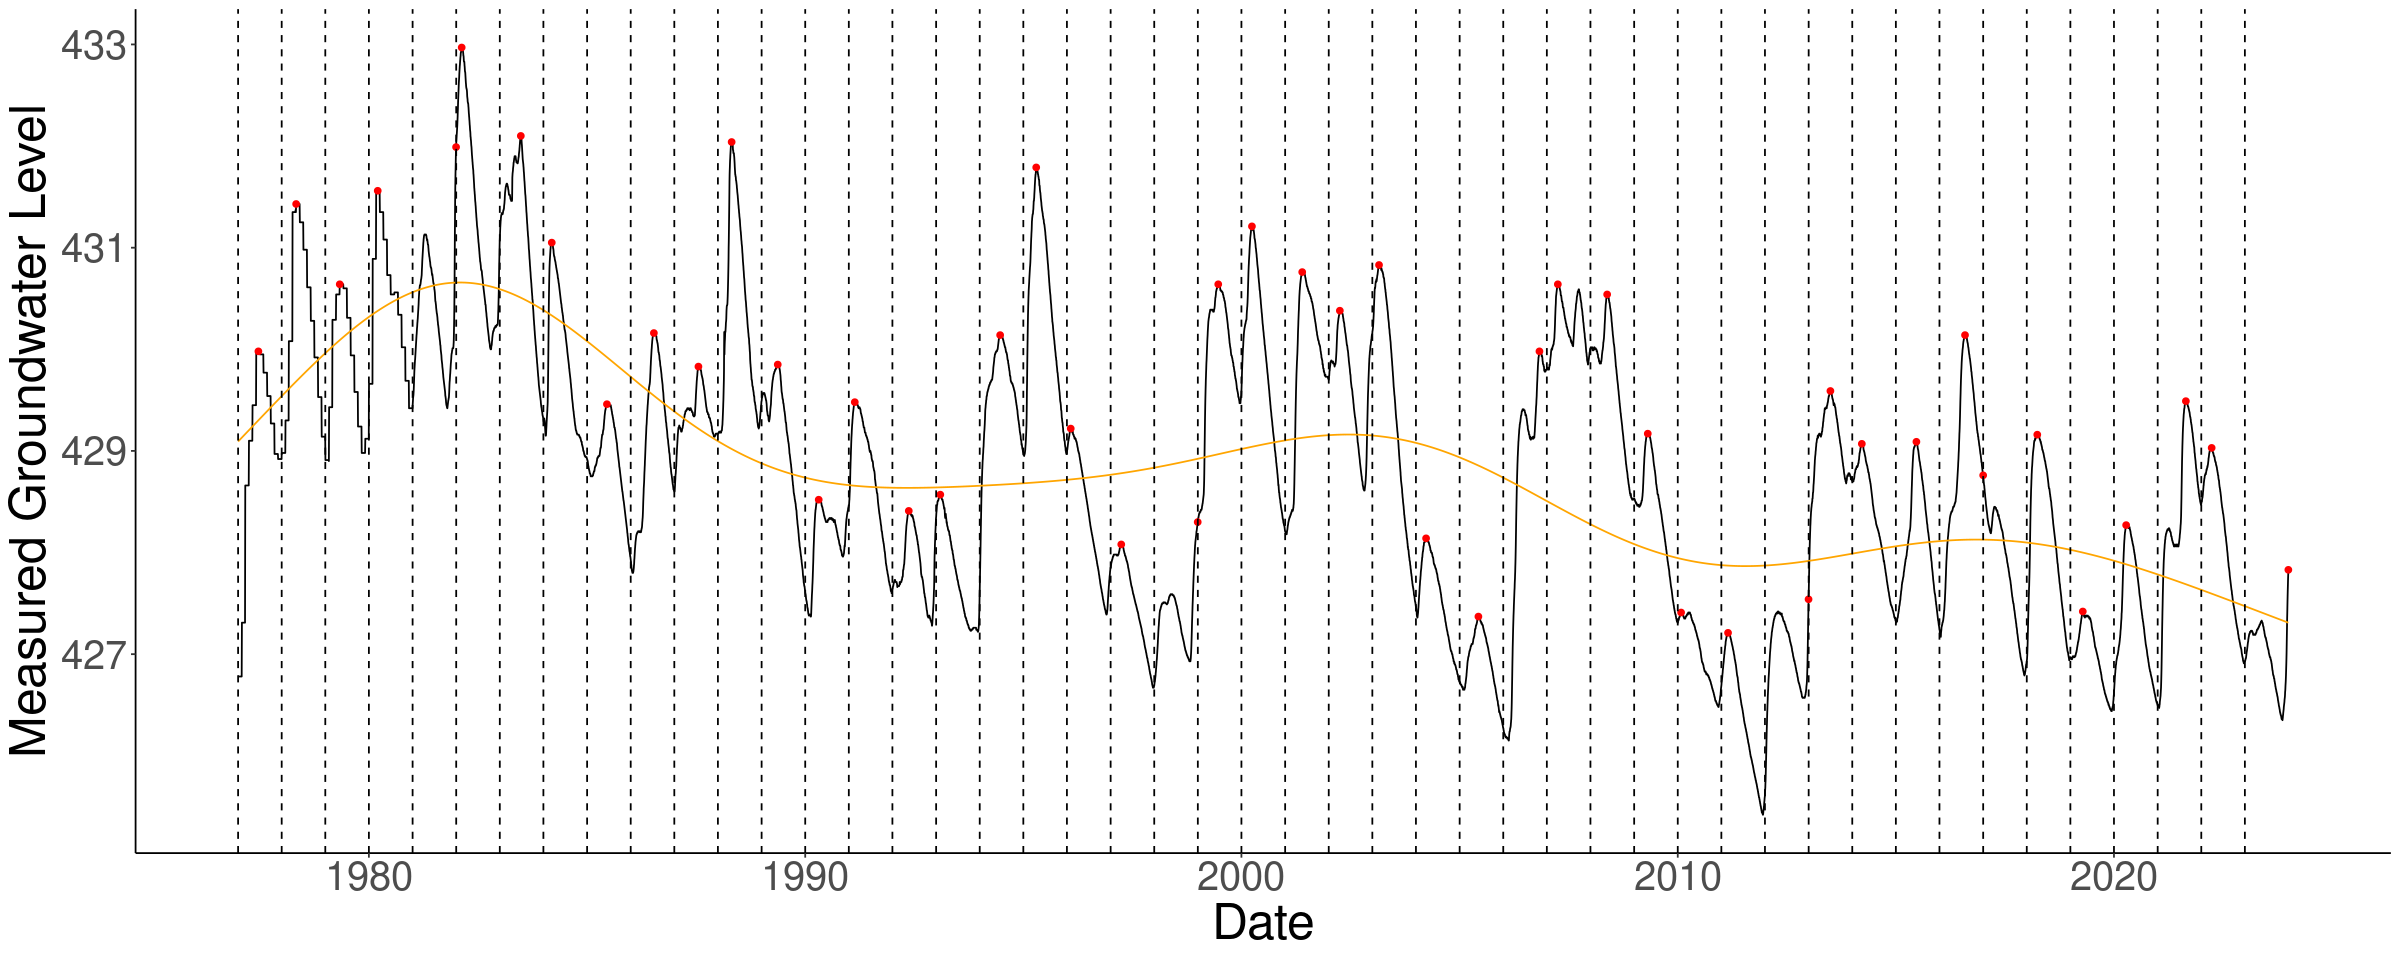

In [6]:
# Use the ggplot2 package to display the time series
ggplot(data) + #create plot object
    geom_line(data = data, aes(x = Zeitstempel, y = Wert)) + # add time series of measurements
    geom_point(data = data_yearly_maxima, aes(x = Date_maxima, y = Max), color = "red") + #add maxima as red points
     geom_line(data = data, aes(x = Zeitstempel, y = trend), color = "orange") + #add trend line
    geom_vline(xintercept = dmy(paste0("01-01-",seq(min(data$Jahre), max(data$Jahre), by = 1))), linetype = "dashed") + #add vertical line for each year
    theme_classic() +
    theme(text = element_text(size = 30))+
    xlab("Date") +
    ylab("Measured Groundwater Level")

The estimated trend, in orange, is following the data reasonably well with a downard trend in time and several oscilliations.

We now plot the standardized time series, i.e., the data from which the trend has been removed, to vizually check that the new time series is now stationary in time.

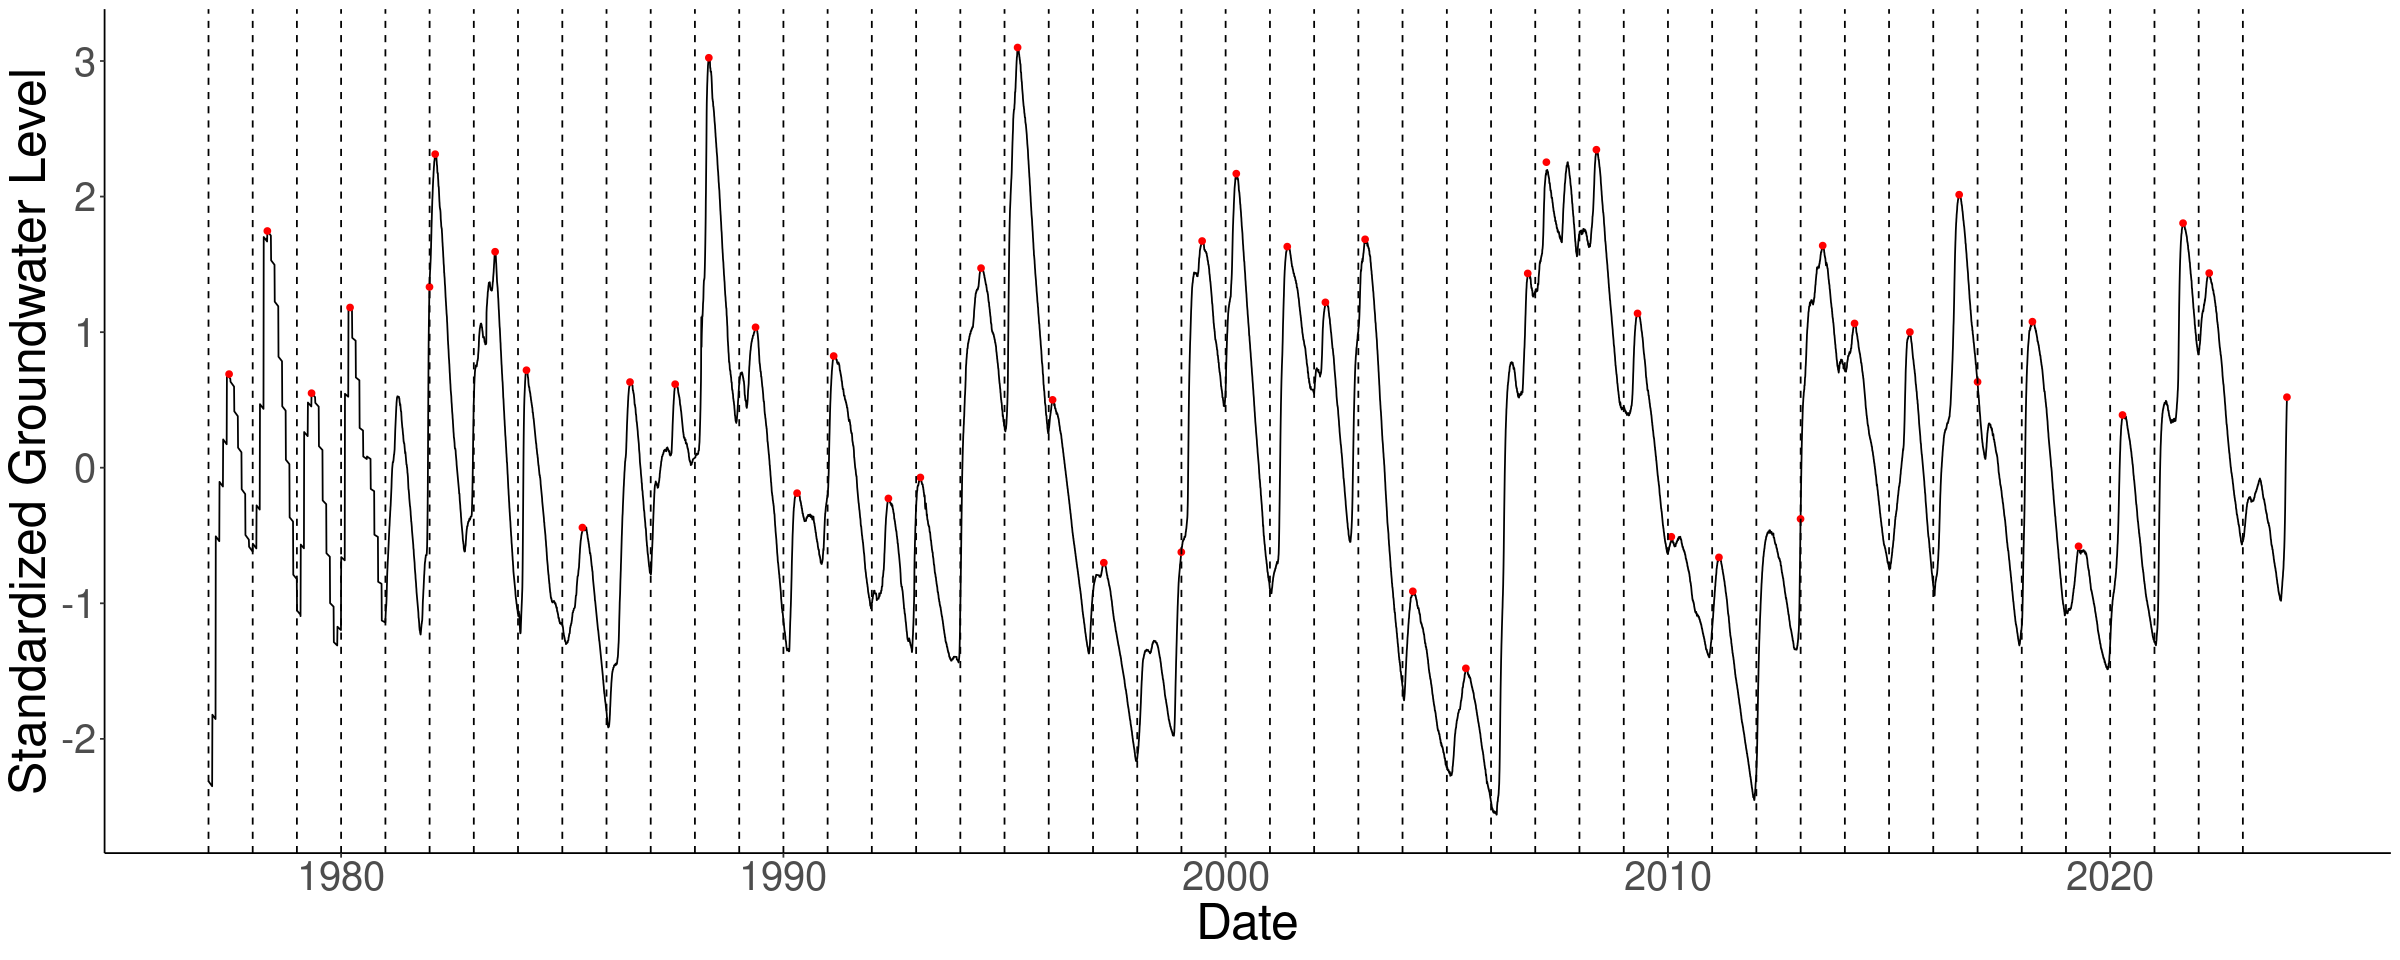

In [7]:
# We compute the yearly maxima of both the standardized and non-standardize data
data_yearly_maxima <- data %>%
                        group_by(Jahre) %>%
                        summarize(Max = max(Wert, na.rm = TRUE),
                                  Max_standardized = max(Wert_standardized, na.rm = TRUE),
                                  Date_maxima = Zeitstempel[which.max(Wert)])

# Use the ggplot2 package to display the time series
ggplot(data) + #create plot object
    geom_line(data = data, aes(x = Zeitstempel, y = Wert_standardized)) + # add time series of measurements
    geom_point(data = data_yearly_maxima, aes(x = Date_maxima, y = Max_standardized), color = "red") + #add maxima as red points
    geom_vline(xintercept = dmy(paste0("01-01-",seq(min(data$Jahre), max(data$Jahre), by = 1))), linetype = "dashed") + #add vertical line for each year
    theme_classic() +
    theme(text = element_text(size = 30))+
    xlab("Date") +
    ylab("Standardized Groundwater Level")

For the above plots, we observe that there is no obvious trend in time meaning that the `mgcv` package successfully removed the trend making the "indentically distributed" assumption more realistic. We will now check the second assumption, i.e., the independence of yearly maxima.

## Checking the independence of yearly maxima measurements

Independence of the yearly maxima will be checked thanks to an auto-correlation function: we compute the correlation between the maxima at year `y` and values at year `y + lag`. The empirical estimate of the function can be computed automatically using the function `acf`.

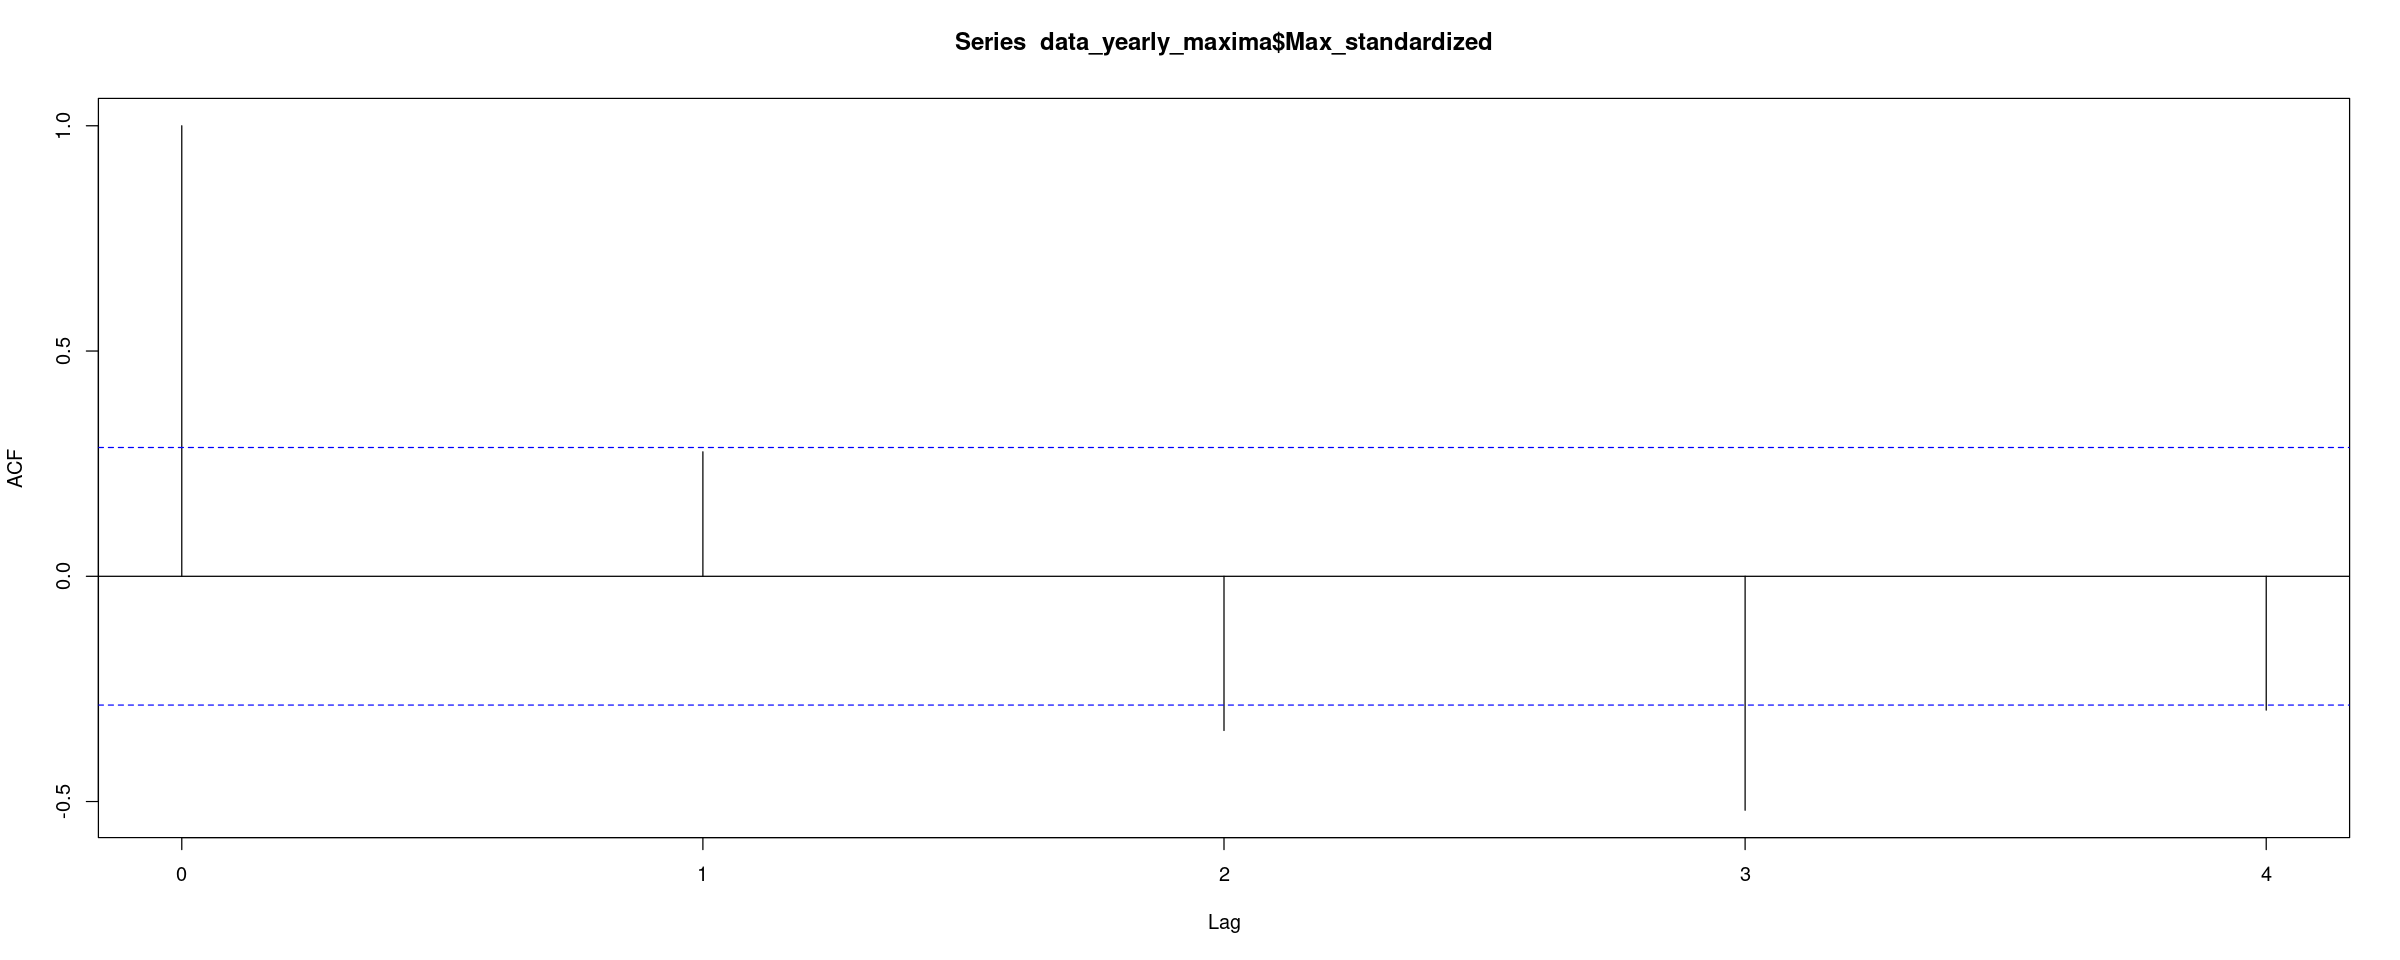

In [8]:
#Compute the auto-correlation between yearly maxima
acf(data_yearly_maxima$Max_standardized, lag = 4, na.action = na.pass)

The function's value at lag `0` is equal to `1` and corresponds to the perfect match between a maxima and itself. At lag `lag = 1`, the correlation is below the dashed blue line, meaning that there is no evidence in favour of a correlation greater than `0`. On the contrary, we obserbe that for lags `lag = 2,3`, the correlation exceeds the dashed blue line, meaning that there is  evidence that there is a residual  correlation between yearly maxima: the assumption of independence between measurements does not seem valid.

The trend removal standardization did fully remove dependence, so we will need to lower the dependence between measurements with other means. In partical, we will increase the block size to 2 years, or more if necessary.

*<ins>Comment</ins>*: An alternative means to lower dependence while maintaining the size of the sample could be to compute block maxima over blocks of days with another starting date than January 1st. This solution would be relevant if we observe a large number of pairs of consecutive maxima belonging to the same "peak". Such behaviour is not observed in this example so we favour the larger block size solution.

In [9]:
#Initialize datafrmwe with first row of maxima dataframe
data_yearly_maxima_largerblock <- data_yearly_maxima[1,]

# Define new block size (number of years)
block_size <- 2

#Compute the maxima of the new larger blocks
for(i in 1:floor(dim(data_yearly_maxima)[1] / block_size)){
    indexes <- (block_size) * (i - 1) + 1:block_size #Index for years belonging to the same block
    pos <- which.max(data_yearly_maxima$Max_standardized[indexes]) # Find maxima within block
    data_yearly_maxima_largerblock[i,] <- data_yearly_maxima[indexes[pos],] # Store new block maxima
    data_yearly_maxima_largerblock[i,1] <- min(data_yearly_maxima$Jahre[indexes]) # Keep first year of block as reference
}

# Display the first 6 rows
head(data_yearly_maxima_largerblock)

Jahre,Max,Max_standardized,Date_maxima
<dbl>,<dbl>,<dbl>,<date>
1977,431.43,1.7461657,1978-05-02
1979,431.56,1.1819516,1980-03-15
1981,432.97,2.3129213,1982-02-16
1983,432.10,1.5932971,1983-06-26
1985,430.16,0.6321081,1986-07-14
1987,432.04,3.0239007,1988-04-25


We can now check that with the new block size, the maxima measurements are independent by computing again the autocorrelation fuction.

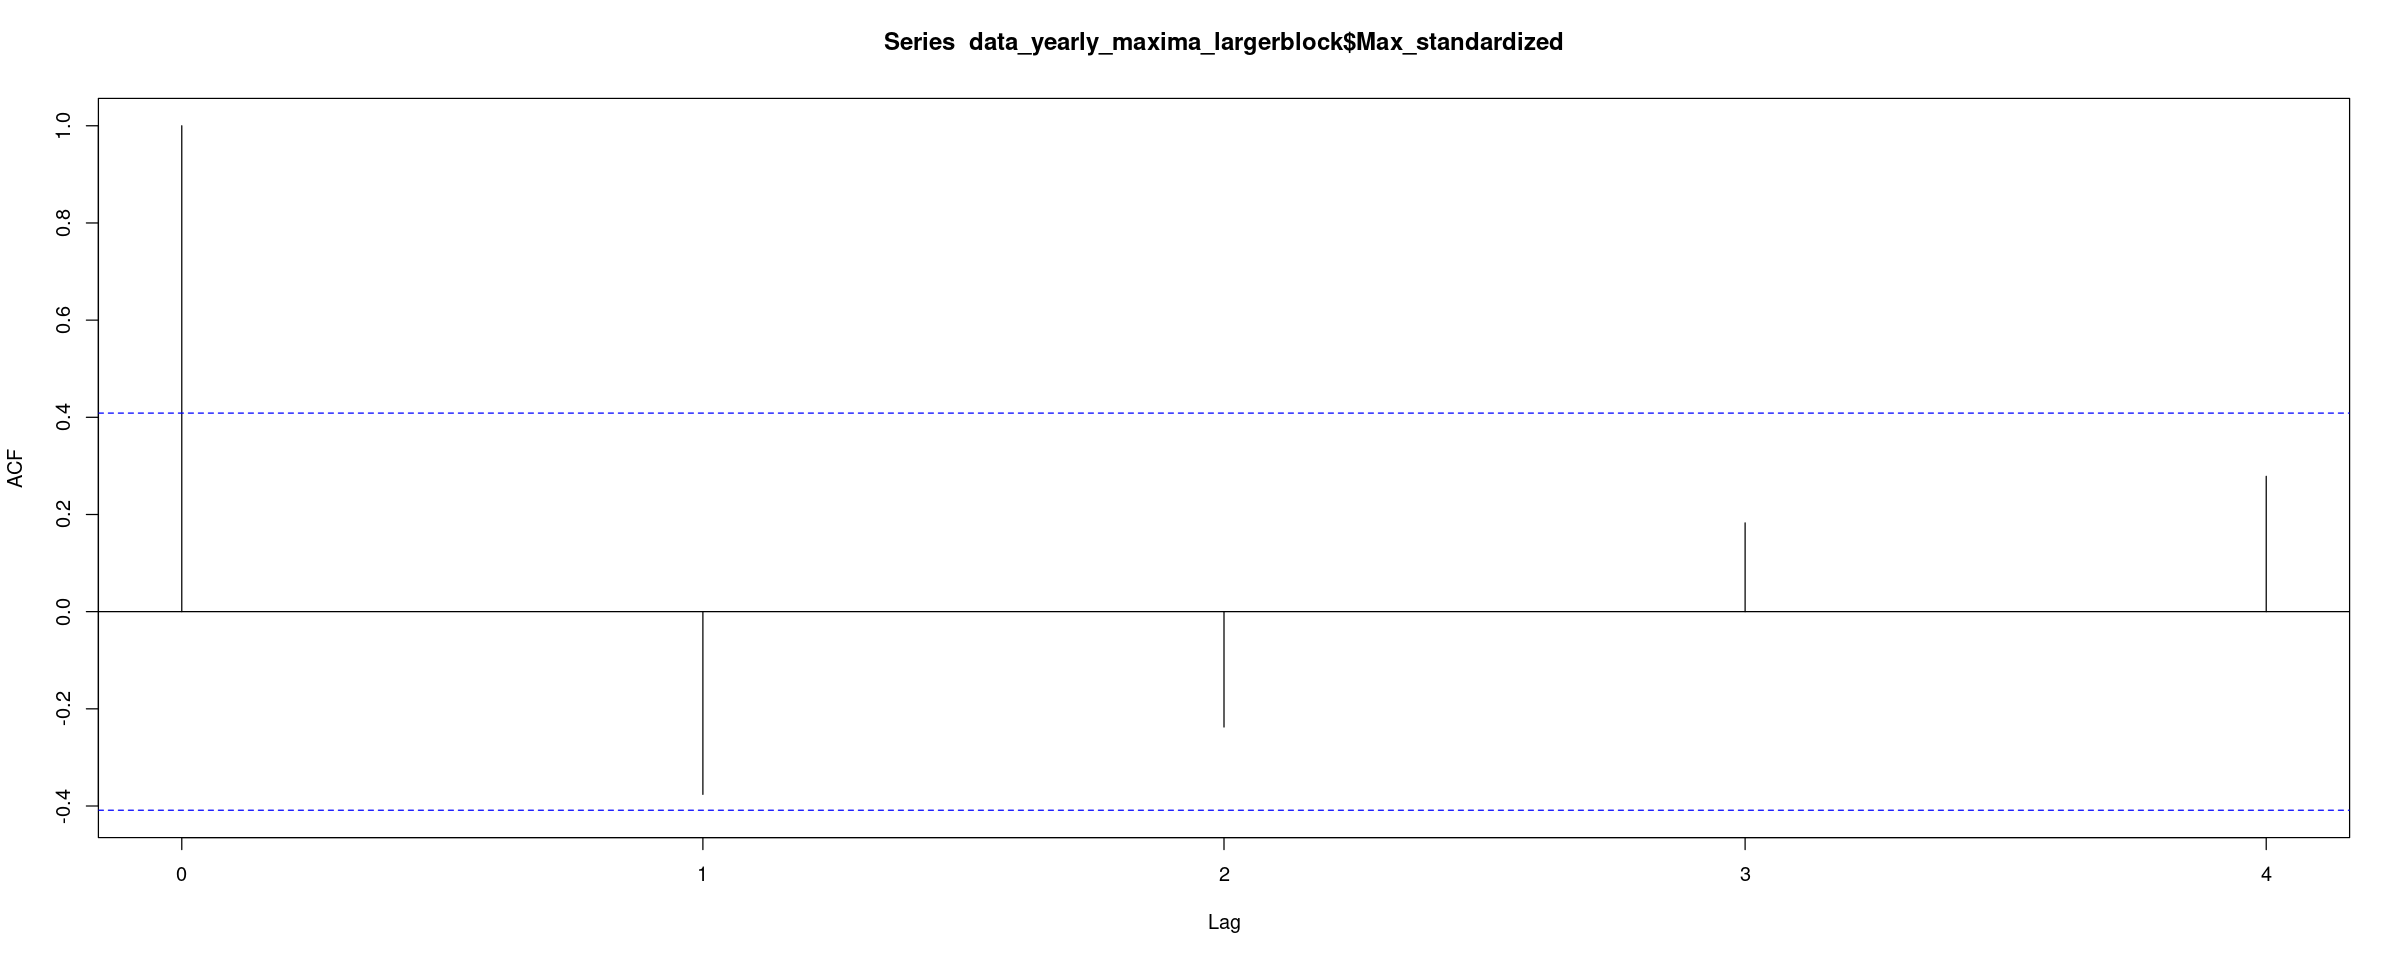

In [10]:
#Compute the auto-correlation between yearly maxima
acf(data_yearly_maxima_largerblock$Max_standardized, lag = 4, na.action = na.pass)

We now observe that the empirical correlation does not exceed the dashed blue line for any lag greater that `lag > 0`. We can conclude that there is no evidence that measurements are dependent: all assumptions for statistical analysis are met and we can now move to the next step, i.e., model estimation and selection.

We can also display the results of the block size increase on the maxima:

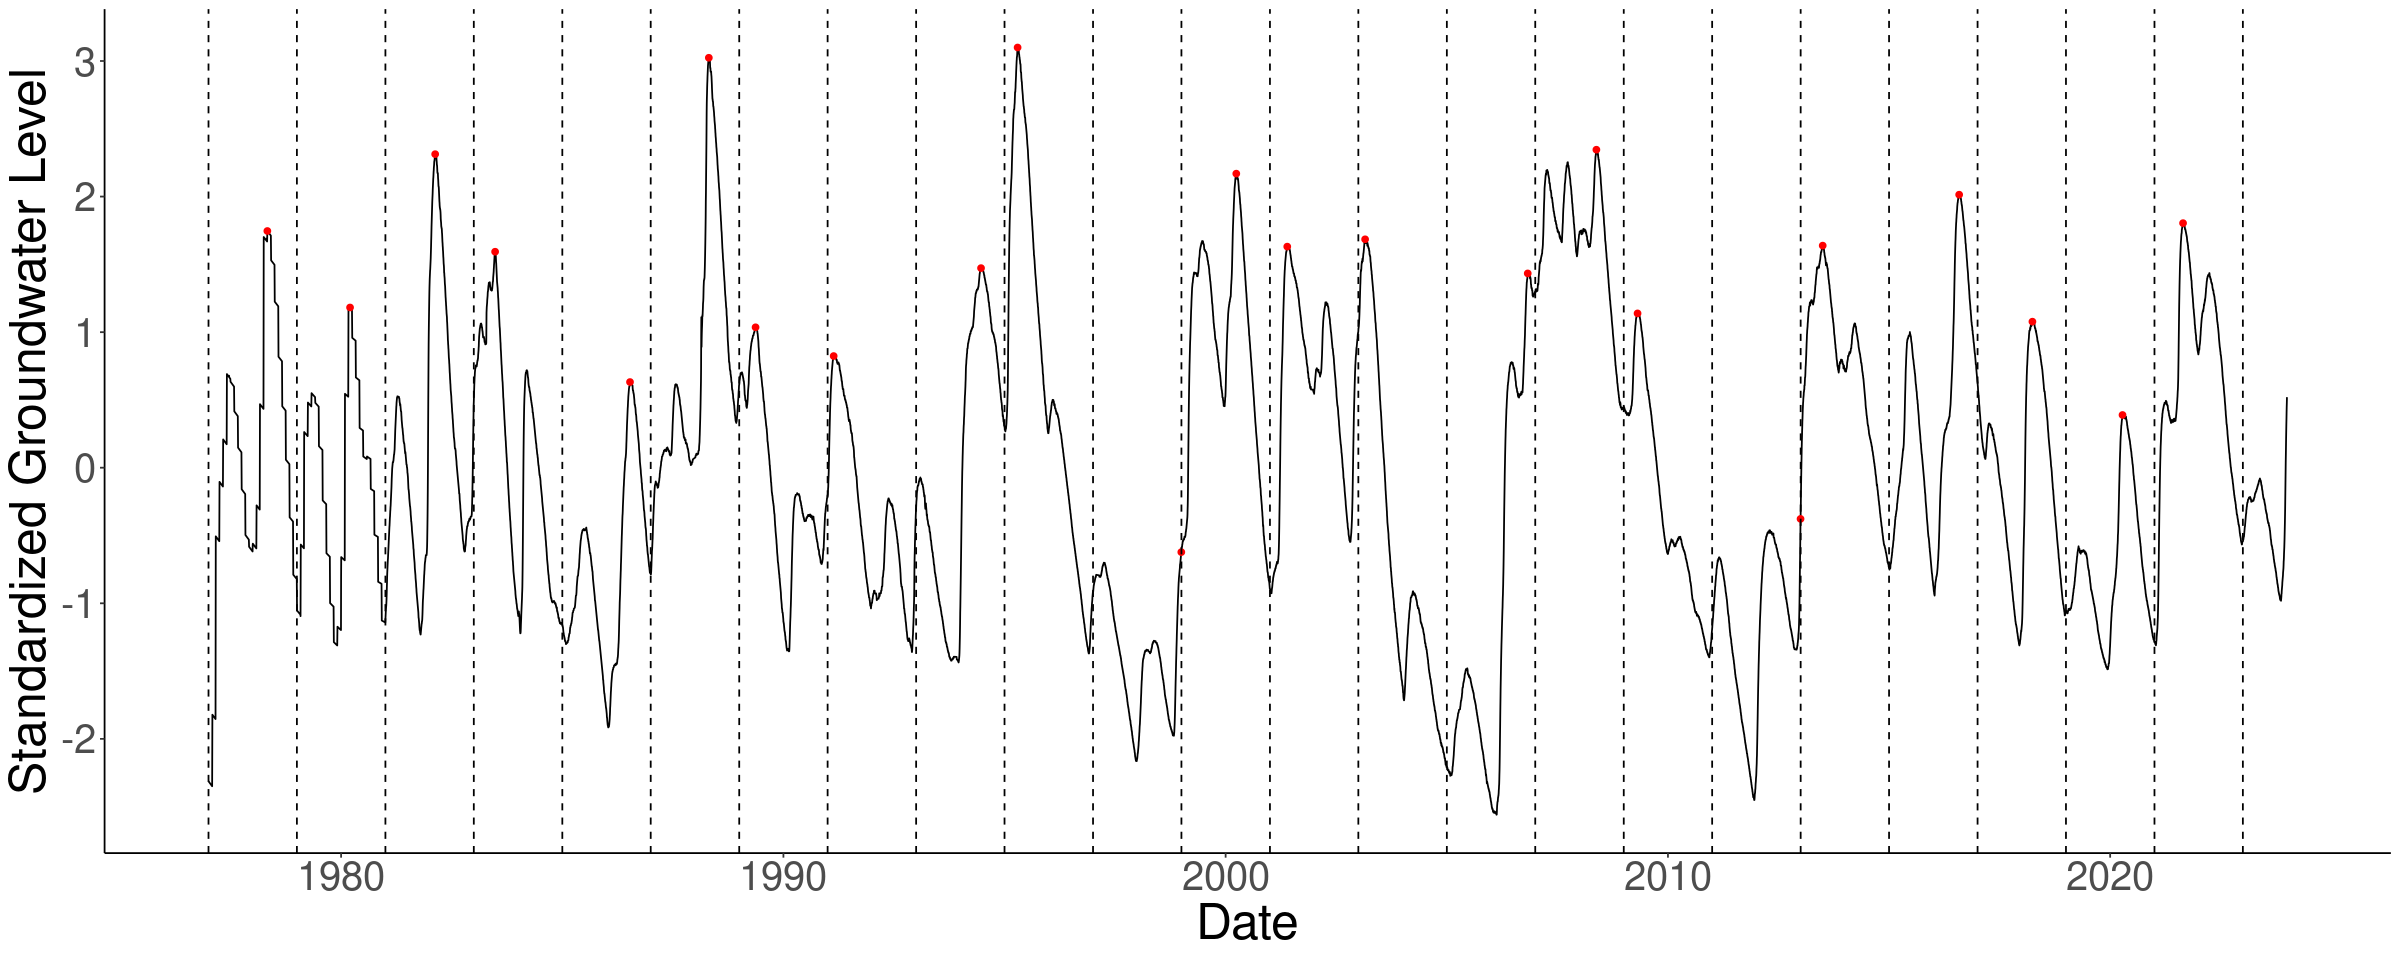

In [13]:
# Use the ggplot2 package to display the time series
ggplot(data) + #create plot object
    geom_line(data = data, aes(x = Zeitstempel, y = Wert_standardized)) + # add time series of measurements
    geom_point(data = data_yearly_maxima_largerblock, aes(x = Date_maxima, y = Max_standardized), color = "red") + #add maxima as red points
    geom_vline(xintercept = dmy(paste0("01-01-",seq(min(data$Jahre), max(data$Jahre), by = 2))), linetype = "dashed") + #add vertical line for each year
    theme_classic() +
    theme(text = element_text(size = 30))+
    xlab("Date") +
    ylab("Standardized Groundwater Level")

We observe that the 2011-2012 block yields a maxima that correspond to the same event than the next block, so we attempt block shifting to further improve the independence. In order to get independent peaks, we shift blocks backward in time.

In [28]:
#Define block starting date for the first year
starting_date <- ymd("1976-12-01")

# Compute number of days to shift date
number_of_days_since_start_of_year <- starting_date - min(data$Zeitstempel)

# Compute block index by shifted years
data$block_index <- year(data$Zeitstempel - number_of_days_since_start_of_year) - min(data$Jahre)

#Compute yearly maxima for shifted blocks
data_yearly_maxima_shifted <- data %>%
                        group_by(block_index) %>% # Groupe lines by year
                        summarize(Max = max(Wert, na.rm = TRUE),
                                  Max_standardized = max(Wert_standardized, na.rm = TRUE),
                                  Date_maxima = Zeitstempel[which.max(Wert)]) # Compute yearly maxima and date of occurence

# Filter block maxima data to remove first 2 months of measurements corresponding to the shifted block
data_yearly_maxima_shifted <- data_yearly_maxima_shifted %>% filter(block_index != -1)

#Display first 6 rows of the dataframe
head(data_yearly_maxima_shifted) 

block_index,Max,Max_standardized,Date_maxima
<dbl>,<dbl>,<dbl>,<date>
0,429.98,0.6906684,1977-06-20
1,431.43,1.7461657,1978-05-02
2,430.64,0.5499222,1979-05-02
3,431.56,1.1819516,1980-03-15
4,431.13,0.5268368,1981-04-10
5,432.97,2.3129213,1982-02-16


We now computed the maxima over shifted blocks of increased size.

In [29]:
#Initialize datafrmwe with first row of maxima dataframe
data_yearly_maxima_shifted_largerblock <- data_yearly_maxima_shifted[1,]

# Define new block size (number of years)
block_size <- 2

#Compute the maxima of the new larger blocks
for(i in 1:floor(dim(data_yearly_maxima)[1] / block_size)){
    indexes <- (block_size) * (i - 1) + 1:block_size #Index for years belonging to the same block
    pos <- which.max(data_yearly_maxima_shifted$Max_standardized[indexes]) # Find maxima within block
    data_yearly_maxima_shifted_largerblock[i,] <- data_yearly_maxima_shifted[indexes[pos],] # Store new block maxima
    data_yearly_maxima_shifted_largerblock[i,1] <- min(data_yearly_maxima_shifted$block_index[indexes]) # Keep first year of block as reference
}

# Display the first 6 rows
head(data_yearly_maxima_shifted_largerblock)

block_index,Max,Max_standardized,Date_maxima
<dbl>,<dbl>,<dbl>,<date>
0,431.43,1.7461657,1978-05-02
2,431.56,1.1819516,1980-03-15
4,432.97,2.3129213,1982-02-16
6,432.10,1.5932971,1983-06-26
8,430.16,0.6321081,1986-07-14
10,432.04,3.0239007,1988-04-25


We now plot the time series using the shifted block maxima to assess if there is some form of improvement.

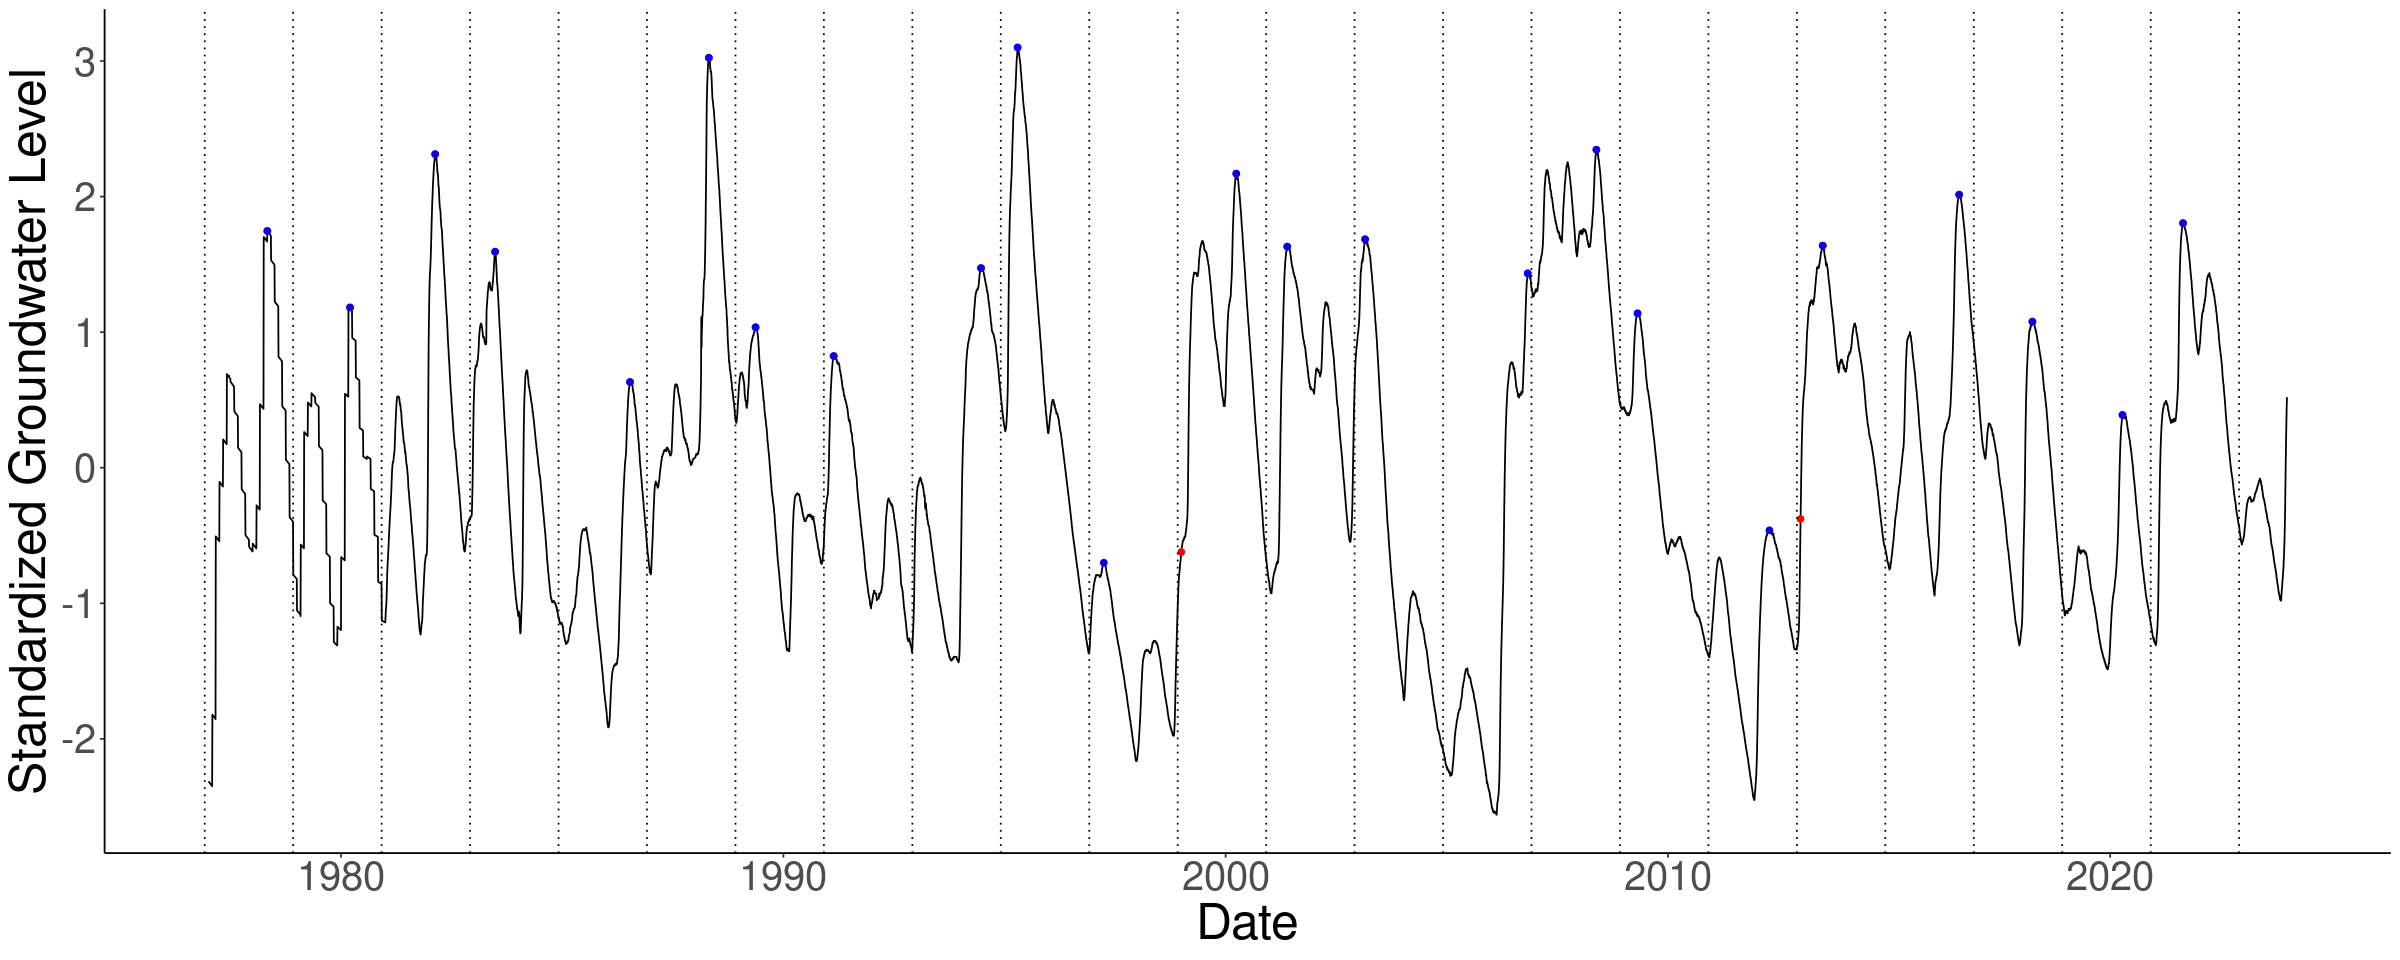

In [30]:
# Use the ggplot2 package to display the time series
ggplot(data) + #create plot object
    geom_line(data = data, aes(x = Zeitstempel, y = Wert_standardized)) + # add time series of measurements
    geom_point(data = data_yearly_maxima_largerblock, aes(x = Date_maxima, y = Max_standardized), color = "red") + #add maxima as red points
    geom_point(data = data_yearly_maxima_shifted_largerblock, aes(x = Date_maxima, y = Max_standardized), color = "blue") + #add maxima of shifted block as blue points
    geom_vline(xintercept = dmy(paste0("01-01-",seq(min(data$Jahre), max(data$Jahre), by = 2))) + number_of_days_since_start_of_year, linetype = "dotted") + #add vertical line for each year
    theme_classic() +
    theme(text = element_text(size = 30))+
    xlab("Date") +
    ylab("Standardized Groundwater Level")

We now have observations that all belongs to independent peaks which improves the credibility of the independence assumption.

## Model estimation and selection

We estimate and select a parametric model for the block maxima observations. As we have less than `100` observations, we will prefer L-moment matching over maximum likelihood estimation as the former is known to provide more robust estimates for small sample sizes.

We consider three models:
* <ins> Generalized Extreme Value (GEV)</ins> : the model is theoretically motivated as it appears as the asymptotic distribution for the distribution of block maxima of increasing size. It is thus a natural candidate for observations representing the maxima over a block.
* <ins> Log-Pearson III</ins>: this model is extremely popular in hydrology. It is parametrized with the same number of parameters than the GEV, and is sometime found to be a better fit to the data. Its popularity makes it an important candidate.
* <ins> Weibull distribution</ins>: the Weibull model is a specific case of the GEV when the model admits an upper bound. We observe empirically that groundwater level usually falls into this category. Estimating directly a Weibull distribution instead of a GEV sometime can provide a better fit to the data when the added constraint that there is an upper bound to the data is realistic, see the guidelines' report for more details.

We thus use the `R` package `lmom` to estimate the parameters the three candidate models.

In [31]:
#Comput l-moments of the observations
lmom <- samlmu(data_yearly_maxima_shifted_largerblock$Max_standardized)

#Estimate GEV parameters
gev <- pelgev(lmom)

#Estimate log-Pearsonn III parameters
pIII <- pelpe3(lmom)

# Compute Weibull parameters
wei <- pelwei(lmom)

print("GEV Parameters:")
gev
print("Weibull Parameters:")
wei
print("Log-Pearson III:")
pIII

[1] "GEV Parameters:"


xi     alpha         k 
1.1906478 0.9842434 0.4541459

[1] "Weibull Parameters:"


zeta      beta     delta 
-4.711535  6.535626  7.872465

[1] "Log-Pearson III:"


mu      sigma      gamma 
 1.4385210  0.9276398 -0.5556747

We now have parameters estimates for all the three candidate models. We will select the best fitting one by computing their respective negative-log likelihood and choosing the one with the lowest value.

In [32]:
print("Neg-log likelihood:")
(paste0("GEV: ",-sum(log(evd::dgev(data_yearly_maxima_shifted_largerblock$Max_standardized, loc = gev[1], scale = gev[2], shape = -gev[3])))))
(paste0("Weibull: ",-sum(log(dweibull(data_yearly_maxima_shifted_largerblock$Max_standardized - wei[1],scale = wei[2], shape = wei[3])))))
(paste0("Pearson3: ",-sum(log(dgamma(abs(data_yearly_maxima_shifted_largerblock$Max_standardized - (pIII[1] - 2 *  pIII[2] /  pIII[3])), shape = 4/(pIII[3])^2, scale =  pIII[2] * abs(pIII[3]) / 2)))))

[1] "Neg-log likelihood:"


[1] "GEV: 30.0685944426959"

[1] "Weibull: 30.0006464392306"

[1] "Pearson3: 30.0143247523272"

We observe that the model with minimal negative log-likelihood is the Weibull distribution whose parameters are estimated directly. The GEV estimation also covers Weibull distributions but the estimation method yields parameters values that are less likely than Pearson III and direct Weibull.

We thus choose the Weibull model with direct parameters' estimates to compute the return level function of the yearly maxima.

## Return level function estimation

The selected parametric model can be translated into a return level function, i.e., the expected groundwater level yearly maxima expected to be observed in average every return period (in years).

We also quantify the uncertainty associated to the estimated model in order to check if the selected model is consistent with the observed data. To do so, we will use a parametric boostrap method, i.e., a form a Monte Carlo sampling, that allows to quantify the uncertainty of the estimated return levels.

In [33]:
#Import all necessary functions
source("utils.r")

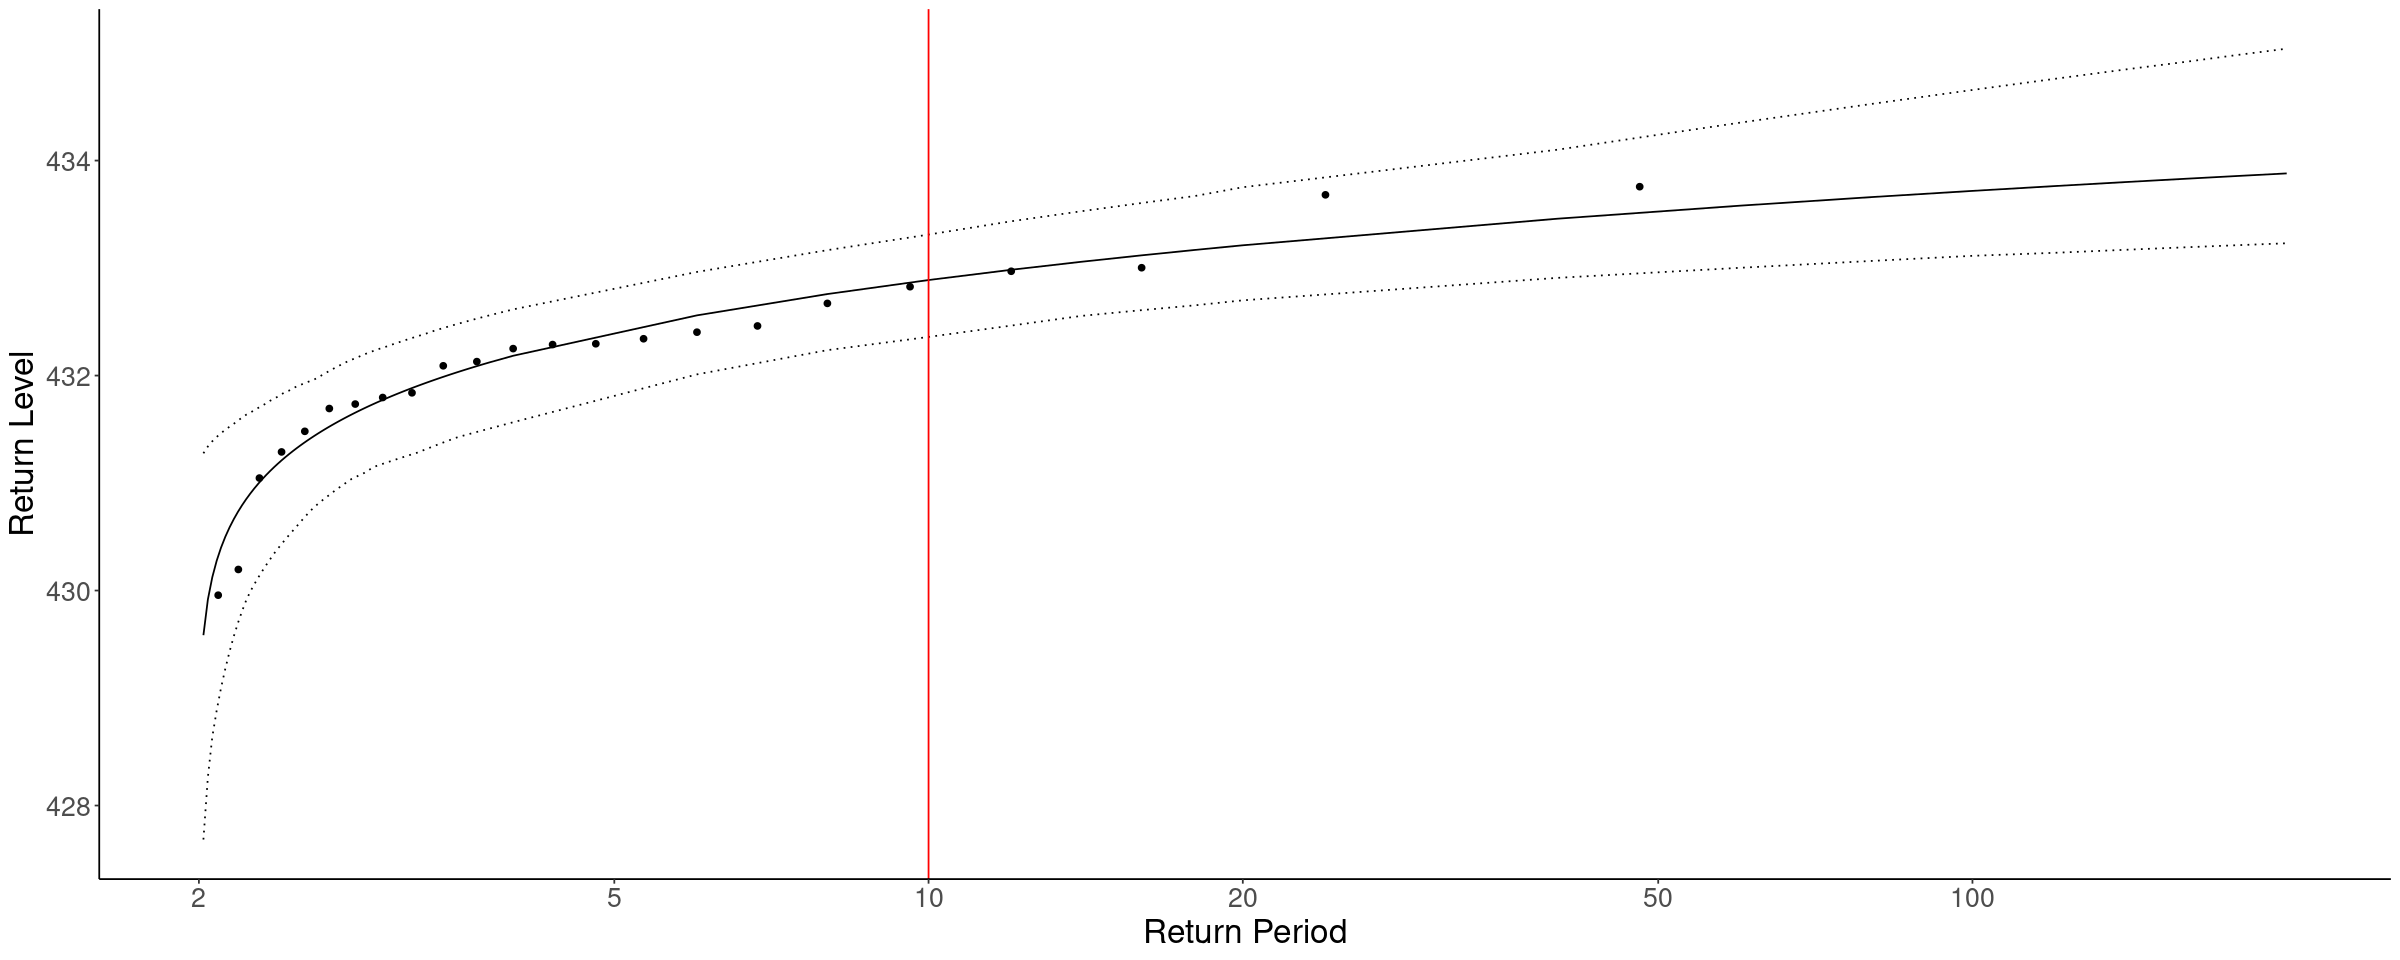

In [34]:
#Compute and plot the return level function and its associated uncertainty
display_return_level_function(data = data_yearly_maxima_shifted_largerblock$Max_standardized, # Maxima data
                              parameters = wei, #Estimated model's paramters
                              block_size = block_size, # Block size (in year) used to compute maxima
                              max_trend = max(data$trend)) #Maximal value of the estimated trend

We observe that all maxima lie inside the uncertainty bound, namely the 99% confidence interval represented by the dotted black lines: the estimated model is thus consistent with observations. The strenght of the parametric model described here is its capacity to extrapolate return level beyond the range of observed data. When using distributions covered by the GEV model such extrapolation is mathematically grounded in asymptotic theory.

We are now ready to compute the estimated return level for a given return period, in particular the 10 years return level that is particularly important for groundwater level regulation.

*<ins>Note on uncertainty quantification</ins>*: the confidence interval is obtained thanks to a bootstrap procedure. By nature, such technique for uncertainty quantification is random so the CI values might differ slightly from one execution to the other. Either rounding values to a sufficiently rough approximate, or increasing the bootstrap sample size `m` (at the cost of an increased computing time), would limit such variability to a low enough level. Note also that this procedure might not be fully robust for the Weibull model as for small sizes, samples might not be consistent with the existence of an upper bound yielding unconsistent bootstrap sample that needs to be rejected.

In [36]:
# Compute the desires return level and its uncertainty
return_levels <- compute_return_level(return_period = 10, # Desired return period
                                      parameters = wei, # Parameters estimated from the selected model
                                      n_obs = length(data_yearly_maxima_shifted_largerblock$Max_standardized), #Number of observations use for the estimation
                                      block_size = block_size, #Block size (in years) used to compute maxima
                                      max_trend = max(data$trend), # Maximum value of the trend to compute all time high
                                      m = 1000 # Number of bootstrap samples for uncertainty quantification
                                     )
return_levels

Return_period,Return_level,Lower_99_CI_bound,Upper_99_CI_bound
<dbl>,<dbl>,<dbl>,<dbl>
10,432.8887,432.3589,433.2975


We now have an estimate of the retrun level and its associated confidence interval that can be used as reference when designing civil engineering infrastructures compliant with the Swiss regulation.